In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from pybandstructure import *
import graphene

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
a = 100 #[nm] lattice period
hv = 0.658 #hbar v_D [eV*nm]
E_SQUARED = 1.4399764 #[eV*nm]
n_x = 10
G_max = 10 #max reciprocal lattice vector considered

delta = 0.0
density = 0.01 #electron density in [nm^-2]
temperature = 0.005 #k_B T in eV
eta = 0.002 #energy smoothing [eV]

In [3]:
#lenght of reciprocal lattice vector
G = 2 * np.pi / a
k_cutoff = 0.5 * (2 * G_max + 1) * G
n_sites = (n_x, (2 * G_max + 1) * n_x)
reciprocal_lattice_basis = np.array([[G, 0.],
                                     [0.,2 * k_cutoff]], dtype = float)

#select point group (D2 for rectangular lattice with 2 reflection symmetries)
#angle of the principal axis
theta0 = np.arctan2(reciprocal_lattice_basis[1,0],reciprocal_lattice_basis[0,0])
point_group = Point_Group.dihedral_group(n =2, theta0 = theta0)
#point_group = point_groups.Point_Group(space_dimension=2)

#defines lattice geometry given Bravais lattice 
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group = point_group)    
reciprocal_lattice_vectors = sample.Sample.line_sample(basis_vectors = reciprocal_lattice_basis, cut_off = G_max * G)


k_sample = sample.Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= reciprocal_lattice_basis, denominator=n_sites)
#k_sample = sample.Unit_Cell_Sample.irreducible_wigner_seitz_cell(basis_vectors= reciprocal_lattice_basis, point_group = point_group, denominator=n_sites)

C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


energy cut-off =  0.4341052728730377


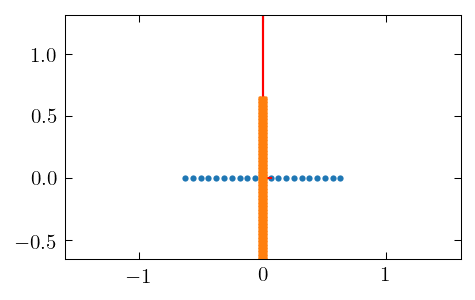

In [4]:
reciprocal_lattice_vectors.plot()
k_sample.plot(ms = 1)
print('energy cut-off = ', hv * k_cutoff)

In [5]:
#################### Hamiltonian and overlap matrices ##########################
class kinetic_function():
    def __init__(self, hv, der = (0,0)):
        self.hv = hv
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return hv * k
        elif self.der == (1,0):
            return hv * np.array([1.,0.])
        elif self.der == (0,1):
            return hv * np.array([0.,1.])
        else:
            return np.array([0,0])

H0 = Momentum_Conserving_Operator(matrices =  [[pauli_matrix('x'), pauli_matrix('y')], pauli_matrix('z')],
                                  coefficients = [kinetic_function(hv = hv), delta],
                                  collapse = True)
                                                  
H = build_kinetic_hamiltonian(H0, 
                              reciprocal_lattice_vectors = reciprocal_lattice_vectors)  

potential_components_S = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
potential_components_S[reciprocal_lattice_vectors[(1,0)]] = 1./2
potential_components_S[reciprocal_lattice_vectors[(-1,0)]] = 1./2
US = build_potential_hamiltonian(U = pauli_matrix('I'), 
                                potential_components =potential_components_S, 
                                reciprocal_lattice_vectors = reciprocal_lattice_vectors)

potential_components_A = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
potential_components_A[reciprocal_lattice_vectors[(1,0)]] = -1./(2j)
potential_components_A[reciprocal_lattice_vectors[(-1,0)]] = 1./(2j)
UA = build_potential_hamiltonian(U = pauli_matrix('I'), 
                                potential_components =potential_components_A, 
                                reciprocal_lattice_vectors = reciprocal_lattice_vectors)

p_x = build_kinetic_term([pauli_matrix('x'), pauli_matrix('y')], 
                           kinetic_function(hv=hv,der=(1,0)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)
p_y = build_kinetic_term([pauli_matrix('x'), pauli_matrix('y')], 
                           kinetic_function( hv=hv,der=(0,1)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)

In [6]:
US(0)

array([[0. +0.j, 0. +0.j, 0.5+0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0.5+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       ...,
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0.5+0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, ..., 0.5+0.j, 0. +0.j, 0. +0.j]])

In [7]:
kf_vals = 1/np.linspace(0.2/G, 4/G,num=5)
chi = []
for kf in kf_vals:
    density = kf**2/ np.pi
    uS = .01 * max(temperature, hv* kf)#[eV]
    uA = .02 * max(temperature, hv* kf)#[eV]
    band_structure = Band_Structure.from_hamiltonian(
        k_sample = k_sample,
        hamiltonian = H + 2. * uS *US + 2. * uA * UA,
        degeneracy = 4,
        zero_filling = len(reciprocal_lattice_vectors),
        density = density,
        temperature = temperature)
    band_structure.compute_bands()
    #plt.figure()
    #band_structure.plot(contour = [(0,-n_x),(0,n_x)])
    nS = band_structure.average_operator(US) 
    nA = band_structure.average_operator(UA) 
    print(np.allclose(nS/uS,nA/uA))
    #print(abs((nS/uS -nA/uA)/(nS/uS +nA/uA)))
    print(np.real(nS/uS), np.real(graphene.chi(omega = 0, q= G, Ef = band_structure.chemical_potential)))
    chi.append(nS/uS)
    

  2%|█▌                                                                             | 40/2100 [00:00<00:05, 392.20it/s]

True
-0.3028496741379823 -0.30350655638279755


  2%|█▍                                                                             | 39/2100 [00:00<00:05, 386.13it/s]

True
-0.05071865426706956 -0.051127102613352966


  2%|█▍                                                                             | 37/2100 [00:00<00:05, 366.33it/s]

True
-0.03003894824288137 -0.027450079786912277


  2%|█▎                                                                             | 36/2100 [00:00<00:05, 360.00it/s]

True
-0.02598522258652761 -0.024591826469977148


100%|█████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:06<00:00, 300.39it/s]

True
-0.024864338192204325 -0.024067146126095493


(0, 2)

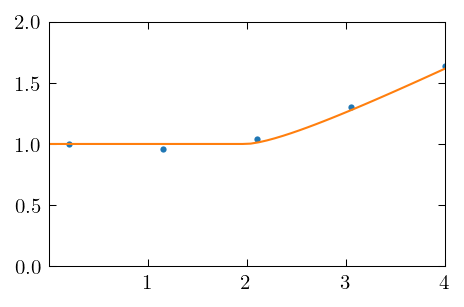

In [8]:
plt.plot(G/kf_vals, -np.array(np.real(chi))/(2*kf_vals/(np.pi * hv)),'o')
q= np.linspace(0.0001,4) 
plt.plot(q, -np.real(graphene.chi(omega = 0., q = q, Ef = hv)/(2 /(np.pi*hv))))
plt.ylim(0,2)

In [9]:
density = 0.01
temperature = 0.005
uS = 0.05
uA = -0.02
band_structure = Band_Structure.from_hamiltonian(
        k_sample = k_sample,
        hamiltonian = H + 2. * uS *US + 2. * uA * UA,
        degeneracy = 4,
        zero_filling = len(reciprocal_lattice_vectors),
        density = density,
        temperature = temperature)

In [10]:
superlattice = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)
superlattice.band_structure.compute_bands()

100%|█████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:03<00:00, 584.28it/s]


In [11]:
e_vals = np.linspace(np.amin(superlattice.band_structure.energies), np.amax(superlattice.band_structure.energies),num= 500)
e_lims = e_vals[0], e_vals[-1] #energy limits for the figure
dosvals = superlattice.dos(e_vals, shape = 'fermi') 

Text(0.5, 0, '$\\epsilon~[{\\rm eV}]$')

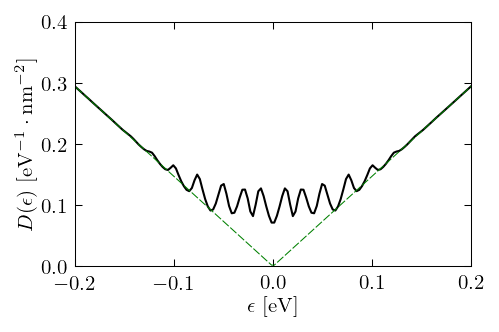

In [12]:
plt.plot(e_vals, dosvals, c='k')
plt.plot(e_vals, 2* abs(e_vals)/(np.pi * hv**2),'--', c='g', lw=0.5)
plt.ylim(0,0.4)
plt.xlim(-0.2,0.2)
plt.ylabel(r'$D(\epsilon)~[{\rm eV^{-1}\cdot nm^{-2}}]$')
plt.xlabel(r'$\epsilon~[{\rm eV}]$')

In [13]:
eps_sub = 5.
alpha = E_SQUARED * a /eps_sub 
eps = 1-alpha * graphene.chi(omega = 0., q = G, Ef = band_structure.chemical_potential)
chi_H = np.real(graphene.chi(omega = 0., q = G, Ef = band_structure.chemical_potential)/eps)
sol = band_structure.compute_sc_bands(operators = [US,UA],
                                transfer_function= lambda x: [np.real(2 * alpha * x[0]), np.real(2 * alpha * x[1])],
                                initial_values = [chi_H * uS , chi_H * uA],
                                options = {'method' : 'broyden1', 'callback' : print})

  2%|█▊                                                                             | 47/2100 [00:00<00:04, 465.34it/s]

[-0.00137336  0.00054934] [-0.00038922  0.00015569]


  2%|█▊                                                                             | 48/2100 [00:00<00:04, 466.04it/s]

[-0.00144087  0.00057635] [ 1.65592203e-06 -6.62366201e-07]
     fun: array([ 1.65592203e-06, -6.62366201e-07])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([-0.00144087,  0.00057635])


100%|█████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:03<00:00, 567.87it/s]


In [14]:
(uS +1j *uA) /(uS +1j *uA+  alpha* sol.x[0] +1j * alpha * sol.x[1] )

(5.879813222589061+7.628268761727978e-09j)

In [15]:
1-alpha * graphene.chi(omega = 0., q = G, Ef = band_structure.chemical_potential)


(5.893122795005322+0j)

In [16]:
eps

(4.7841927703138225+0j)

In [17]:
dosvals_hartree = superlattice.dos(e_vals, shape = 'fermi') 

Text(0.5, 0, '$\\epsilon~[{\\rm eV}]$')

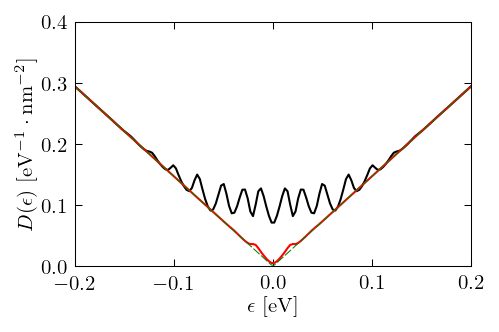

In [18]:
plt.plot(e_vals, dosvals, c='k')
plt.plot(e_vals, dosvals_hartree, c='r')
plt.plot(e_vals, 2* abs(e_vals)/(np.pi * hv**2),'--', c='g', lw=0.5)
plt.ylim(0,0.4)
plt.xlim(-0.2,0.2)
plt.ylabel(r'$D(\epsilon)~[{\rm eV^{-1}\cdot nm^{-2}}]$')
plt.xlabel(r'$\epsilon~[{\rm eV}]$')
